In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA as pc
import math

In [2]:
TrainDf = pd.read_csv('aps_failure_training_set_processed_8bit.csv')
X_all = TrainDf.drop('class',axis=1)
Y = TrainDf['class']
Y = Y.round()
Y = Y.replace(to_replace=-1,value=0)

Test = pd.read_csv('aps_failure_test_set_processed_8bit.csv')
TestFe = Test.drop('class',axis=1)
TestL = Test['class']
TestL = TestL.round()
TestL = TestL.replace(to_replace=-1,value=0)

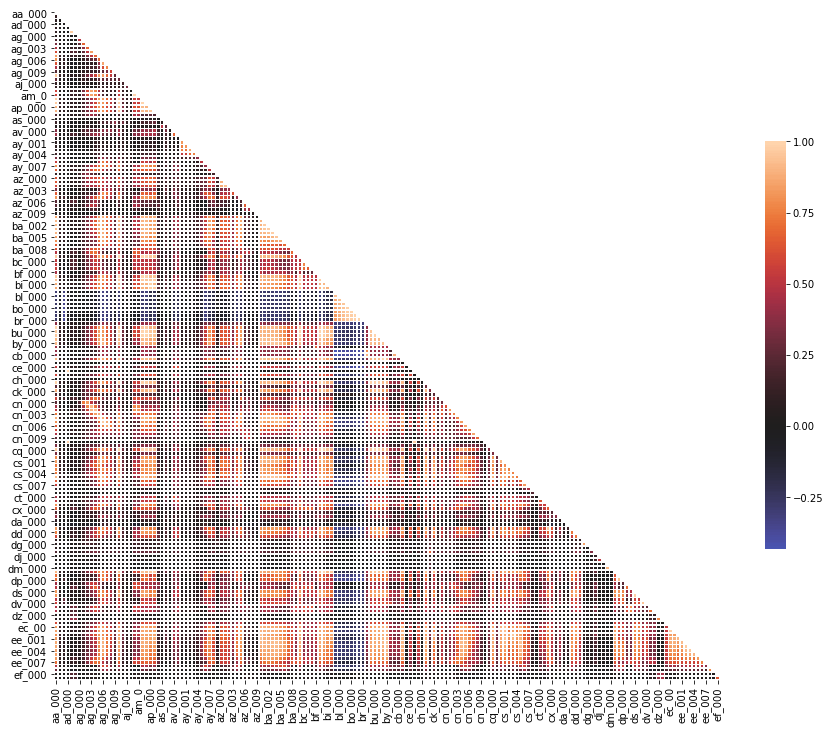

In [3]:
corr = X_all.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(15,15))
a = sns.heatmap(corr, mask=mask, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
figure = a.get_figure()  
figure.savefig('correlationmatrix.png')

In [41]:
X_std = StandardScaler().fit_transform(X_all)
pca_ = pc(n_components=13)
X = pca_.fit_transform(X_std)
TestFstd = StandardScaler().fit_transform(TestFe)
Xtest = pca_.fit_transform(TestFstd)

Xpc = PCA(X_all)
Xtestpc =  PCA(TestFe)
pca_.explained_variance_ratio_

array([0.39400931, 0.06821196, 0.04329023, 0.02594251, 0.02322267,
       0.02221388, 0.01813761, 0.01611043, 0.01372963, 0.01295788,
       0.01136076, 0.01126798, 0.01064559])

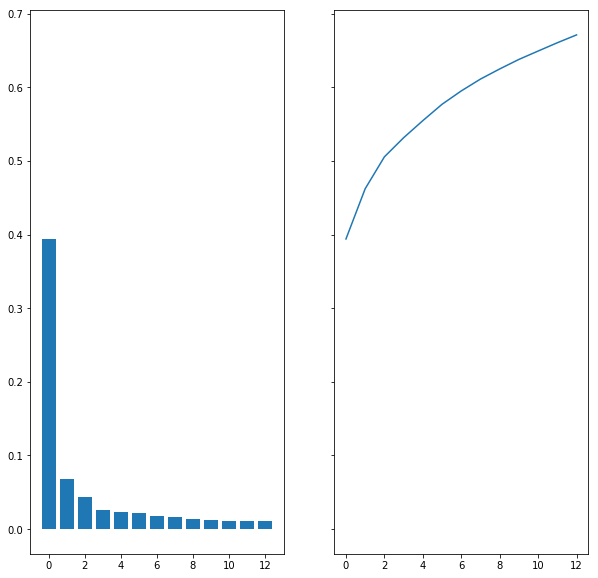

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(10,10), sharey=True)
axs[0].bar([0, 1, 2, 3, 4,5,6,7,8,9,10,11,12], pca_.explained_variance_ratio_)
cumsum = np.cumsum(pca_.explained_variance_ratio_)
axs[1].plot(cumsum) 
fig.savefig('variance.png')

In [37]:
def PCA(X_all):
    X_std = StandardScaler().fit_transform(X_all)
    covM = np.cov(X_std.T)
    eigvalues, eigvectors = np.linalg.eig(covM)
    eig_pairs = [(np.abs(eigvalues[i]), eigvectors[:,i]) for i in range(len(eigvalues))]
    eig_pairs.sort()
    eig_pairs.reverse()
    matrix_w = np.hstack((eig_pairs[0][1].reshape(170,1), 
                      eig_pairs[1][1].reshape(170,1),
                      eig_pairs[2][1].reshape(170,1), 
                      eig_pairs[3][1].reshape(170,1),
                      eig_pairs[4][1].reshape(170,1), 
                      eig_pairs[5][1].reshape(170,1),
                      eig_pairs[6][1].reshape(170,1), 
                      eig_pairs[7][1].reshape(170,1),
                      eig_pairs[8][1].reshape(170,1), 
                      eig_pairs[9][1].reshape(170,1),
                      eig_pairs[10][1].reshape(170,1), 
                      eig_pairs[11][1].reshape(170,1),
                      eig_pairs[12][1].reshape(170,1), 
                      ))
    ProjX = X_std.dot(matrix_w)
    return ProjX

In [7]:
def sigmoid(z):
    a = 1/(1+np.e**(-z))
    a = a.T
    return a

def pi(X,w):
    z = w.T.dot(X.T)
    return np.array(sigmoid(z))

def likelihood(X,y,w):
    summa = 0
    for i in range(len(X)):
        z = np.dot(w.T,X[i])
        summa += (y[i]*(z)-math.log(1 + math.exp(z)))
    return summa

def cost_function(X,y,w):
    #Finding mean error
    num_of_observation = len(y)
    predictions = pi(X, w)
    cost0=[]
    cost1=[]
    for i in range(len(y)):
        if(y[i] == 1 and predictions[i] != 0 ):
            cost1.append(y[i]*math.log(predictions[i]))
            cost0.append(0)
        elif(y[i] == 1 and predictions[i] == 0 ):
            cost0.append(0)
            cost1.append(0)
        elif(y[i] == 0 and predictions[i] != 1):
            cost0.append((1-y[i])*math.log(1-predictions[i]))
            cost1.append(0)
        elif(y[i] == 0 and predictions[i] == 1):
            cost1.append(0)
            cost0.append(0)
            
        
    total_cost = np.array(cost1 + cost0)
    avr_cost = total_cost.sum() / num_of_observation
    return avr_cost

def update(X,y,w,lr):
    w = w.reshape(13,1)
    
    predictions = pi(X,w)
        
    Gradient = np.dot(X.T, (y - predictions ))
    
    Gradient = Gradient / len(X)
    
    Gradient *= lr
    
    w = w + Gradient
    
    return w
def create_mini_batches(X, y, batch_size): 
    mini_batches = [] 
    data = np.hstack((X, y)) 
    np.random.shuffle(data) 
    n_minibatches = data.shape[0] // batch_size 
    i = 0
    for i in range(n_minibatches + 1): 
        mini_batch = data[i * batch_size:(i + 1)*batch_size, :] 
        X_mini = mini_batch[:, :-1] 
        Y_mini = mini_batch[:, -1].reshape((-1, 1)) 
        mini_batches.append((X_mini, Y_mini)) 
    if data.shape[0] % batch_size != 0: 
        mini_batch = data[i * batch_size:data.shape[0]] 
        X_mini = mini_batch[:, :-1] 
        Y_mini = mini_batch[:, -1].reshape((-1, 1)) 
        mini_batches.append((X_mini, Y_mini)) 
    return mini_batches

def train(X, Y, weights, lr, iters):
    costhist = []
    costhist.append(likelihood(X, Y, weights))
    for i in range(iters):
        weights = update(X, Y, weights, lr)
        cost = likelihood(X, Y, weights)
        costhist.append(cost)
        
        if i % 100 == 0:
            print ("iter: " + str(i) + " cost: "+str(cost))

    return weights, costhist

def batchtrain(X, Y, weights, lr, iters,batchsize):
    costhist = []
    costhist.append(likelihood(X, Y, weights))
    for i in range(iters):
        minibatches = create_mini_batches(X,Y,batchsize)
        for m in minibatches:
            xmini, ymini = m
            weights = update(xmini, ymini, weights, lr)
            cost = likelihood(xmini, ymini, weights)
            costhist.append(cost)
        
        if i % 100 == 0:
            print ("iter: " + str(i) + " cost: "+str(cost))

    return weights, costhist

In [5]:
from sklearn.metrics import confusion_matrix

In [33]:
confus = confusion_matrix(TestL, a)

In [35]:
confus

array([[12604,  3021],
       [    6,   369]], dtype=int64)

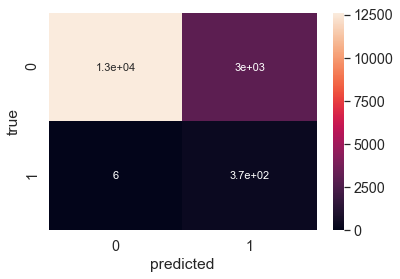

In [166]:
sns.set(font_scale=1.3)
a = sns.heatmap(confus, annot=True,annot_kws={"size": 11})
a.set(xlabel='predicted', ylabel='true')
figure = a.get_figure()  
figure.savefig('correlationmatrix.png')

In [29]:
Y = np.array(Y)
Y = Y.reshape(60000,1)
weights= np.zeros(13)
trainedweights, costhist = train(X,Y,weights,0.01,100)
costhist

iter: 0 cost: [-41490.23865156]


[array([-41588.83083354]),
 array([-41490.23865156]),
 array([-41418.14848464]),
 array([-41364.56712448]),
 array([-41323.93384426]),
 array([-41292.3957227]),
 array([-41267.28481033]),
 array([-41246.75090987]),
 array([-41229.50729915]),
 array([-41214.65583602]),
 array([-41201.56692635]),
 array([-41189.79710606]),
 array([-41179.03233751]),
 array([-41169.04888789]),
 array([-41159.68625248]),
 array([-41150.82835282]),
 array([-41142.39043868]),
 array([-41134.309935]),
 array([-41126.54002672]),
 array([-41119.04514964]),
 array([-41111.79781257]),
 array([-41104.77635159]),
 array([-41097.96333889]),
 array([-41091.3444522]),
 array([-41084.9076691]),
 array([-41078.64269107]),
 array([-41072.54052998]),
 array([-41066.59321014]),
 array([-41060.79355223]),
 array([-41055.13501574]),
 array([-41049.6115831]),
 array([-41044.21767364]),
 array([-41038.94807896]),
 array([-41033.79791378]),
 array([-41028.76257786]),
 array([-41023.83772609]),
 array([-41019.01924447]),
 array(

In [8]:

weights= np.zeros(13)
trainedweights, costhist = batchtrain(X,Y,weights,lr = 0.01, iters = 100,batchsize=32)
costhist

C:\Users\tahir\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


iter: 0 cost: 0


[array([-41588.83083354]),
 array([-21.7979968]),
 array([-21.50712022]),
 array([-22.25298844]),
 array([-21.29368422]),
 array([-21.51503595]),
 array([-22.09099034]),
 array([-21.44550318]),
 array([-21.89591258]),
 array([-22.09982912]),
 array([-21.91252203]),
 array([-21.93892158]),
 array([-21.68340256]),
 array([-22.40271645]),
 array([-21.69143433]),
 array([-20.96173543]),
 array([-21.54683684]),
 array([-21.49159261]),
 array([-21.16924466]),
 array([-21.80360799]),
 array([-23.01183493]),
 array([-21.19969214]),
 array([-22.00269373]),
 array([-22.24257922]),
 array([-21.77052798]),
 array([-21.88459028]),
 array([-21.41216702]),
 array([-22.08433039]),
 array([-21.94580097]),
 array([-21.34038633]),
 array([-22.10955244]),
 array([-21.71925144]),
 array([-21.83281336]),
 array([-21.87010671]),
 array([-21.64477668]),
 array([-21.91560441]),
 array([-21.65478421]),
 array([-22.15163426]),
 array([-20.65909205]),
 array([-22.35413679]),
 array([-22.04573947]),
 array([-21.57

In [30]:
a = pi(Xtest,trainedweights)

In [31]:
for i in range(len(a)):
    if(a[i] != 0.5):
        a[i] = a[i].round()
    else:
        a[i] = 0

In [32]:
TestA = np.array(TestL)
len(TestA)
TestA = TestA.reshape(16000,1)
f = TestA == a
count = 0
for i in range(len(f)):
    if f[i] == True: 
        count += 1 
count/len(TestA)

0.8108125